# KI-Campus: Learn2Trust
## Lektion 5: Segmentierung

### 1. Einführung
In dieser Lektion geht es darum, wie Künstliche Intelligenz in der medizinischen Bildanalyse dazu eingesetzt werden kann, um medizinische Bildobjekte zu segmentieren.

Am Beispiel von Röntgenthoraxdaten, die zur Diagnostik von Pneumonie aquiriert wurden, wird demonstriert, wie ein einfaches Segmentierungsnetzwerk programmiert werden kann. Dieses Netzwerk soll entscheiden, wo sich die Lungenflügel, Schlüsselbeine und das Herz befinden.

In den verschiedenen Unterkapiteln wird zunächst der Beispieldatensatz gezeigt und anschließend durch Netzwerkerstellung, -training und -evaluation geführt.

*Importieren von benötigten Packages und weiteren Dateien:*

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import sys

# import further python files
import network
import utils

import warnings
warnings.filterwarnings("ignore") 

### 2. Datensatz
Der Datensatz für diese Lektion ist der JSRT Datensatz [1]. Dieser enthält 247 konventionelle Röntgenaufnahmen des Thorax. Wenn der Datensatz geladen wurde, werden Beispielbilder visualisiert und optional Segmentierungen angezeigt, die von Experten erstellt wurden und als Grundwahrheit genutzt werden.

*Laden des Datensatzes, der für das Pretraining verwendet wurde (Bilddaten und zugehörige Segmentierungen):*

In [2]:
# load images
imgs_pretrain = torch.load('jsrt_img_and_seg.pth')['JSRT_img'].unsqueeze(1).float()
imgs_pretrain = imgs_pretrain.clone()

# load segmentations
segs_pretrain = torch.load('jsrt_img_and_seg.pth')['JSRT_seg'].long()
segs_pretrain = segs_pretrain.clone()

# rescale images
imgs_pretrain -= 1500
imgs_pretrain /= 1000

# remove two segmentation labels from the data 
# we do this as we are only interested in training the network with 3 target 
# classes (4 inlcuding the background) to later enable a fine-tuning
segs_pretrain[segs_pretrain==2] = 0
segs_pretrain[segs_pretrain==4] = 0

*Darstellung einer 4-Klassen-Segmentierung zum Pretraining des Modells:*

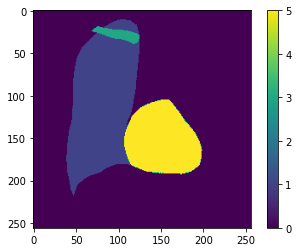

Größe des Datensatz Tensors:  torch.Size([247, 1, 256, 256])
Größe der Bilder (pixel x pixel):  torch.Size([256, 256])
Anzahl der Bilder im Datensatz:  247
Größe des Segmentierungs Tensors:  torch.Size([247, 256, 256])
Anzahl der Label:  4
Verfügbare Label:  tensor([0, 1, 3, 5])


In [3]:
# visualize example segmentation
plt.imshow(segs_pretrain[0])
plt.colorbar()
plt.show()

# print information about the dataset
print("Größe des Datensatz Tensors: ", imgs_pretrain.shape)
print("Größe der Bilder (pixel x pixel): ", imgs_pretrain.shape[2:])
print("Anzahl der Bilder im Datensatz: ", imgs_pretrain.shape[0])
print("Größe des Segmentierungs Tensors: ", segs_pretrain.shape)
print("Anzahl der Label: ", len(segs_pretrain.reshape(-1).unique()))
print("Verfügbare Label: ", segs_pretrain.reshape(-1).unique())

*Laden von 10 Bildern für das Finetuning sowie Laden von Testdaten zur Evaluation des Modells nach Finetuning:*

In [4]:
# load images and segmentations for finetuning
imgs_finetune = torch.load('jsrt_img_and_seg10.pth')['img'].unsqueeze(1).float()
imgs_finetune = imgs_finetune.clone()
segs_finetune = torch.load('jsrt_img_and_seg10.pth')['seg'].long()
   
# load test data
imgs_testset = torch.load('jsrt_img_and_seg_test.pth')['img'].unsqueeze(1).float()
segs_testset = torch.load('jsrt_img_and_seg_test.pth')['seg'].long()
imgs_testset = imgs_testset.clone()

# rescale image values
imgs_testset = (imgs_testset - 1500) / 1000
imgs_finetune = (imgs_finetune - 1500) / 1000

Diese Daten besitzen 2 zusätzlichen Labelklassen, die das Netzwerk segmentieren soll.

*Darstellung einer 6-Klassen-Segmentierung:*

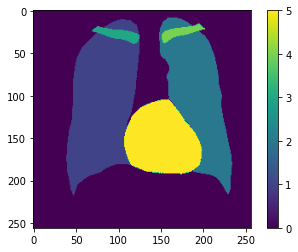

Größe des Datensatz Tensors:  torch.Size([10, 1, 256, 256])
Größe der Bilder (pixel x pixel):  torch.Size([256, 256])
Anzahl der Bilder im Datensatz:  10
Größe des Segmentierungs Tensors:  torch.Size([10, 256, 256])
Anzahl der Label:  6
Verfügbare Label:  tensor([0, 1, 2, 3, 4, 5])


In [5]:
# plot segmentation map
plt.imshow(segs_finetune[0])
plt.colorbar()
plt.show()

# print information about the dataset
print("Größe des Datensatz Tensors: ", imgs_finetune.shape)
print("Größe der Bilder (pixel x pixel): ", imgs_finetune.shape[2:])
print("Anzahl der Bilder im Datensatz: ", imgs_finetune.shape[0])
print("Größe des Segmentierungs Tensors: ", segs_finetune.shape)
print("Anzahl der Label: ", len(segs_finetune.reshape(-1).unique()))
print("Verfügbare Label: ", segs_finetune.reshape(-1).unique())

### 3. Netzwerkarchitektur
Die Netzwerkarchitektur ist das sogenannte MobileNetV3 [2].

In dieser Lektion wird eine bereits vortrainierte Version des Deep-Learning-Modell verwendet. Dieses hat bereits gelernt, den rechten Lungenflügel, das rechte Schlüsselbein und das Herz zu segmentieren. 

*Laden des vortrainierten Modells/Netzwerks:*

In [6]:
# Initialization of the model
model_pretrained = network.lraspp_mobilenet_v3_large()

# Adaptation of the input layer for processing images with one input channel 
# (e.g grayscale images)
model_pretrained.backbone['0'][0] = torch.nn.Conv2d(1,16,3,stride=2,padding=1)

# Adaptation of the classifier for the correct number of classes
# here: four label classes: background, right lung, right collarbone, heart
model_pretrained.classifier.low_classifier = torch.nn.Conv2d(40,4,1)
model_pretrained.classifier.high_classifier = torch.nn.Conv2d(128,4,1)


# Load pretrained network
state_dict = torch.load('Learn2Trust_JSRT_LRASPP_dict.pth')
model_pretrained.load_state_dict(state_dict)

<All keys matched successfully>

*Vorhersage mit auf vier Klassen vortrainiertem KI-Modell:*

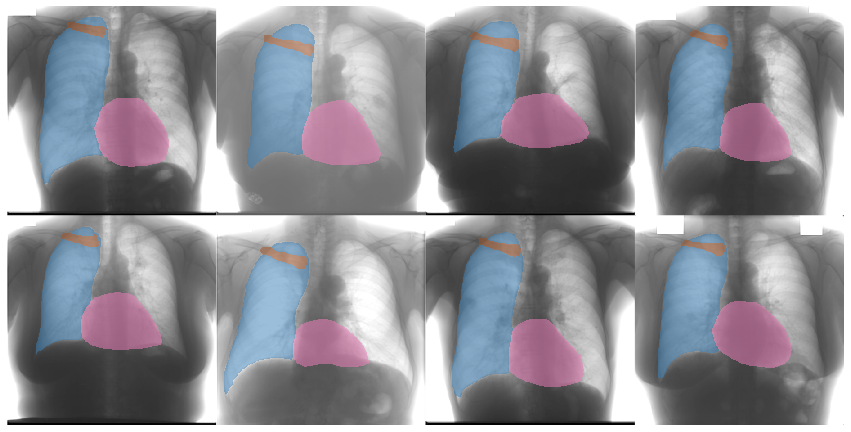

In [7]:
with torch.no_grad():

    # pass through model backbone
    features = model_pretrained.backbone(imgs_pretrain)

    # pass through classifier and argmax()
    prediction_pretrained = F.interpolate(model_pretrained.classifier(features),scale_factor=8,mode='bilinear').argmax(1)
    
    
imcat = utils.cat_images(imgs_pretrain[:8,0],clip=True)
segcat = utils.cat_images(prediction_pretrained[:8])
seg_rgb = utils.color_rgb(imcat,segcat)

fig, ax = plt.subplots()
ax.imshow(imcat,'gray')
ax.imshow(seg_rgb,alpha=0.5, interpolation='None')
ax.axis('off')
fig.set_figheight(15)
fig.set_figwidth(15)

### 4. Fine-Tuning
Das geladene Netzwerk wurde bereits vortrainiert und muss im Folgenden durch ein erneutes Training verfeinert beziehungsweise auf die Segmentierung von fünf Klassen angepasst werden. 

Das vortrainierte Modell zu nutzen und anzupassen, um zusätzlich auch den linken Lungenflügel und das linke Schlüsselbein zu segmentieren, führt zu einem deutlich schnelleren Lernprozess als wenn das Modell komplett neu trainiert werden müsste.

*Anpassungen für das Fine-Tuning:*

In [8]:
# Model for fine-tuning 
model_finetuning = network.lraspp_mobilenet_v3_large()

#first: load weights of pretrained model (same code as in notebook cell #6)
model_finetuning.backbone['0'][0] = torch.nn.Conv2d(1,16,3,stride=2,padding=1)
model_finetuning.classifier.low_classifier = torch.nn.Conv2d(40,4,1)
model_finetuning.classifier.high_classifier = torch.nn.Conv2d(128,4,1)
model_finetuning.load_state_dict(state_dict)


# second: modify architecture for additional label classes

# As two further structures should be learnt during the fine-tuning, 
# the network needs to be able to process these two additional classes.

'''
TODO: MODIFY CLASSIFIER LAYERS
Modify low_classifier and high_classifier of model_finetuning to fit the desired number
of output label classes.
'''
#model_finetuning.classifier.low_classifier = 
#model_finetuning.classifier.high_classifier = 


*Definition verschiedener Trainingsparameter für das Finetuning:*

In [ ]:
# number of epochs for fine-tuning
n_epochs = 2500

# initialize tensor for all loss values
run_loss = torch.zeros(n_epochs)

# initialize optimizer
'''
TODO: OPTIMIZER
set up Adam optimizer (torch.optim.Adam()) to optimize the parameters of model_finetuning 
with a learning rate of 0.001
(see documentation: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html and notebook of lesson 4)
'''
#optimizer = 

# loss function
'''
TODO: LOSS FUNCTION
set up cross entropy loss without class weights
(see documentation: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
'''
#loss_function = 

*Trainingsschleife für das Finetuning:*

Hinweis: Da in diesem Notebook auf die Unterstützung einer Grafikkarte verzichtet wird, kann das Ausführen dieser Zelle einige Minuten dauern.

In [11]:
# fine-tuning
model_finetuning.train()

t0 = t2 = time.time()

for epoch in range(n_epochs):
    
    # draw random data
    idx = torch.randperm(10)[:8]
    img = imgs_finetune[idx]
    seg = segs_finetune[idx]
    
    optimizer.zero_grad()
    
    # perform data augmentation
    img_aug, seg_aug  = utils.aug_img_and_seg(img, seg)
    
    # forward pass
    '''
    TODO: FORWARD PASS
    use model_finetuning to predict for augmented input images (img_aug)
    '''
    #predict = 
    
    # compute loss
    loss = loss_function(predict['out'],seg_aug)    
    
    # backward pass
    loss.backward()
    optimizer.step()

    run_loss[epoch] = loss.item()

    if(epoch%50==49):
        t1 = time.time()
        print(f'iteration {epoch}/{n_epochs}; duration: {round(t1-t2, 2)}s; loss: {run_loss[epoch].item()}')
        t2 = t1
        
t1 = time.time()
print(f'Finetuning finished. Total duration: {round(t1-t0, 2)}s')

iteration 49/2500; duration: 73.55s; loss: 0.1065204069018364
iteration 99/2500; duration: 75.02s; loss: 0.06277896463871002
iteration 149/2500; duration: 76.51s; loss: 0.05248397961258888
iteration 199/2500; duration: 71.07s; loss: 0.045192230492830276
iteration 249/2500; duration: 73.82s; loss: 0.042520921677351
iteration 299/2500; duration: 76.86s; loss: 0.04762471467256546
iteration 349/2500; duration: 80.75s; loss: 0.04310692101716995
iteration 399/2500; duration: 73.52s; loss: 0.03520480543375015
iteration 449/2500; duration: 73.76s; loss: 0.03699834272265434
iteration 499/2500; duration: 74.33s; loss: 0.03314444422721863
iteration 549/2500; duration: 76.34s; loss: 0.03087892383337021
iteration 599/2500; duration: 80.04s; loss: 0.029279444366693497
iteration 649/2500; duration: 75.78s; loss: 0.032069653272628784
iteration 699/2500; duration: 69.73s; loss: 0.030630851164460182
iteration 749/2500; duration: 75.78s; loss: 0.02883037179708481
iteration 799/2500; duration: 82.08s; los

*Plotten der Loss-Kurve:*

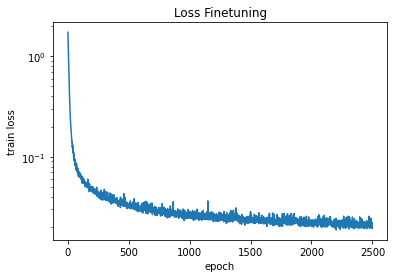

In [13]:
# plot loss curve
plt.semilogy(run_loss[:n_epochs])
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('Loss Finetuning')
plt.show()

### 5. Evaluation
Im vorherigen Unterkapitel Training wurde das Modell einem erneuten Training unterzogen. Dieses Modell soll jetzt während der sogenannten Inferenz auf die Testdaten angewendet werden, um zu evaluieren, wie gut das Modell die Bilder segmentieren kann, die ihm während der Trainingsphase noch nicht präsentiert wurden.

Während der Evaluation wird der Dice-Koeffizient bestimmt, der die Genauigkeit der Segmentierung angibt.

*Evaluation und Ausgabe der Ergebnisse:*

In [14]:
# evaluation
model_finetuning.cpu()

with torch.no_grad():    

    # pass through model backbone
    features = model_finetuning.backbone(imgs_testset)

    # pass through classifier and argmax()
    prediction = F.interpolate(model_finetuning.classifier(features), scale_factor=8, mode='bilinear').argmax(1)
    
d0 = torch.zeros(len(imgs_testset),5)
for i in range(len(imgs_testset)):
    d0[i] = utils.dice_coeff(segs_testset[i].contiguous(),prediction[i].contiguous(),6)
    
print(len(imgs_testset), ' Testbilder zur Evaluation' )
print(f'\nMittelwert über alle Labelklassen: {d0.mean()}\n\nMittelwert Dice-Koeffizient für einzelne Labelklassen:\n  Label1: Rechter Lungenflügel: {d0[:,0].mean()}\n  Label2: Linker Lungenflügel: {d0[:,1].mean()}\n  Label3: Rechtes Schlüsselbein: {d0[:,2].mean()}\n  Label4: Linkes Schlüsselbein: {d0[:,3].mean()}\n  Label5: Herz: {d0[:,4].mean()}\n')

10  Testbilder zur Evaluation

Mittelwert über alle Labelklassen: 0.9680884480476379

Mittelwert Dice-Koeffizient für einzelne Labelklassen:
  Label1: Rechter Lungenflügel: 0.9905017614364624
  Label2: Linker Lungenflügel: 0.9872643351554871
  Label3: Rechtes Schlüsselbein: 0.9446762800216675
  Label4: Linkes Schlüsselbein: 0.9265542030334473
  Label5: Herz: 0.9914461374282837



*Visualisierung von acht segmentierten Testdatensätzen:*

torch.Size([512, 1024]) torch.Size([512, 1024])


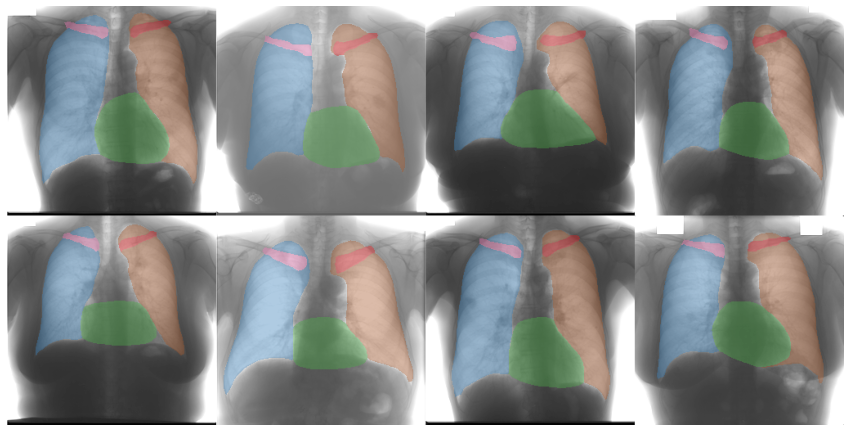

In [15]:
# plotting
imcat = utils.cat_images(imgs_testset[:8,0].cpu(),True)
segcat = utils.cat_images(prediction[:8])
print(imcat.shape, segcat.shape)
imrgb = utils.color_rgb(imcat,segcat)
f = plt.figure()
plt.imshow(imcat,'gray')
plt.imshow(imrgb,alpha=0.4)
plt.axis('off')
f.set_figheight(15)
f.set_figwidth(15)

*Visualisierung der gelernten Merkmale:*

In [16]:
# features
with torch.no_grad():
    features = model_finetuning.backbone(imgs_testset)
    features['low'] = features['low'].cpu().float()
    features['high'] = features['high'].cpu().float()
    
    print("Größe der 'low' Features: ", features['low'].shape)
    print("Größe der 'high' Features: ", features['high'].shape)

Größe der 'low' Features:  torch.Size([10, 40, 32, 32])
Größe der 'high' Features:  torch.Size([10, 960, 16, 16])


visualisations for channel_low # 37


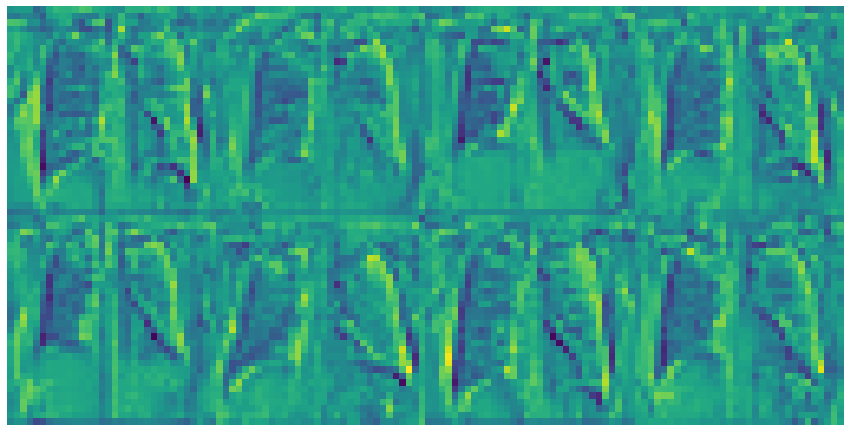

In [17]:
channel_low = torch.randint(0, features['low'].shape[1] - 1, (1,))
print('visualisations for channel_low #', channel_low.item())

imcat = utils.cat_images(features['low'][:8, channel_low], clip=False, size=32)

fig, ax = plt.subplots()
ax.imshow(imcat)
ax.axis('off')
fig.set_figheight(15)
fig.set_figwidth(15)

visualisations for channel_high # 566


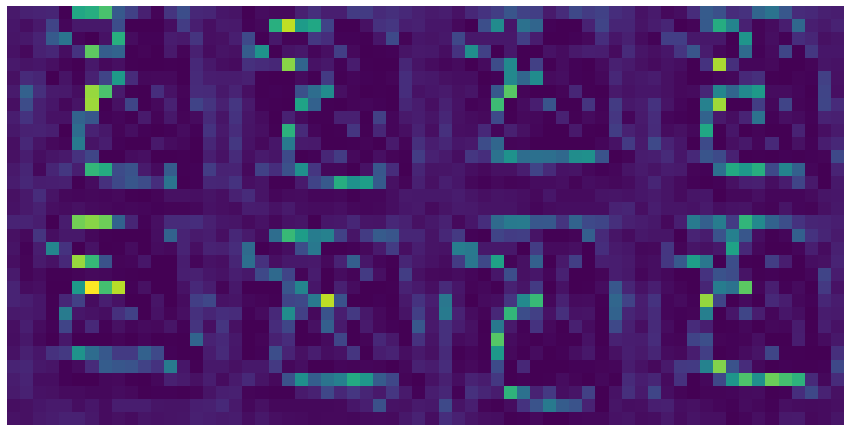

In [18]:
channel_high = torch.randint(0, features['high'].shape[1] - 1, (1,))
print('visualisations for channel_high #', channel_high.item())

imcat = utils.cat_images(features['high'][:8, channel_high:(channel_high + 1)].mean(1), clip=False, size=16)

fig, ax = plt.subplots()
ax.imshow(imcat)
ax.axis('off')
fig.set_figheight(15)
fig.set_figwidth(15)

[1] *Shiraishi, Junji, et al. "Development of a digital image database for chest radiographs with and without a lung nodule: receiver operating 
                  characteristic analysis of radiologists' detection of pulmonary nodules." American Journal of Roentgenology 174.1 (2000): 71-74.*
                  
[2]  *Howard, Andrew, et al. "Searching for mobilenetv3." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019.* (Link zu Preprint: https://arxiv.org/abs/1905.02244)